In [2]:
import os
import cv2
import csv
import glob
import json
import pprint

import math
import numpy as np
import pandas as pd

import scipy
import matplotlib.pyplot as plt

In [3]:
#FRAME NUMBER, NUMBER OF HITS, HIT INTENSITY, TUG, RING DROP, JERK, MOTiON SMOOTHNESS 

In [4]:
df = pd.read_csv('/home/kunaldargan/ROBO_SURGERY/expert_scores_trainee_scores.csv')

In [5]:
df

,Video,Hand-eye Coordination,Instrument-Tissue Manipulation,Dexterity,Flow of procedure,Effectualness,Overall
0,E1_t1,3,3,3,3,4,15
1,E1_t2,3,3,3,2,1,8
2,E1_t3,4,3,4,4,4,18
3,E1_t4,3,2,4,4,4,16
4,E1_t5,3,3,4,4,4,17
5,E1_t6,3,3,4,4,4,17
6,E1_t7,4,4,4,4,4,20
7,E1_t8,3,3,4,4,4,17
8,E1_t9,4,4,4,4,4,20
9,E1_t10,4,3,4,4,4,19


In [6]:
df.columns

Index(['Video', 'Hand-eye Coordination', 'Instrument-Tissue Manipulation',
       'Dexterity', 'Flow of procedure', 'Effectualness', 'Overall'],
      dtype='object')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd8915268d0>,
      dtype=object)

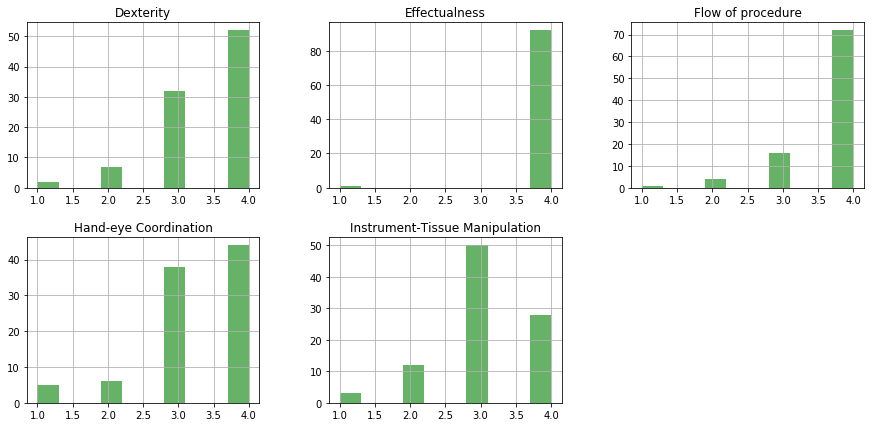

In [7]:
# Evaluation Metrics histogram
df.hist(color='g', column=['Hand-eye Coordination', 'Instrument-Tissue Manipulation',
       'Dexterity', 'Flow of procedure', 'Effectualness'], alpha=0.6, bins=10, layout=(2,3), figsize=(15,7))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd88f3c4940>]],
      dtype=object)

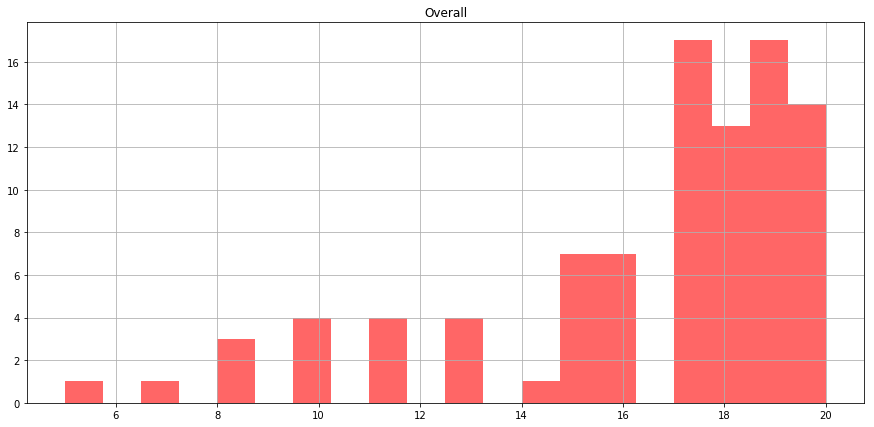

In [8]:
# Overall Score Histogram
df.hist(color='r', column=['Overall'], alpha=0.6, bins=20, figsize=(15,7))

In [9]:
HEC = df["Hand-eye Coordination"].tolist() 
ITM = df["Instrument-Tissue Manipulation"].tolist() 
Dex = df["Dexterity"].tolist() 
FOP = df["Flow of procedure"].tolist() 
Eff = df["Effectualness"].tolist() 
ALL = df["Overall"].tolist() 

# Processing Hand Selected Features and Tracking Features

In [10]:
def process_input(input_file):
    next(input_file)
    high,low=0, 0;
    frame_number, hits, hit_intensity,tug_event, tug, ring_drop_event, jerk, motion_smoothness, time = 0,0,0,0,[],0,0,0,0;
    for row in input_file:
        frame_number = int(row["#"])
        hits = hits + int(row[" H"])
        
        if int(row[" H"]) and int(row[" HI"]):
            high = high+1
        elif int(row[" H"]) and not int(row[" HI"]):
            low = low+1
        
        tug.append(int(row[" T"]))
        
        ring_drop_event = ring_drop_event+int(row[" R"]) 
        jerk = jerk+int(row[" J"])
        
        if  int(row[" M"]) > motion_smoothness:
            motion_smoothness = int(row[" M"])
    
    tug.append(0) #end
    count=0; #000000111100000011000000111110000000
    f = 0
    total = 0
    
    for i in range(len(tug)):
        if tug[i]==1:
            count= count+1;

        if tug[i]==0 and count:
            total=total+count
            count = 0
            tug_event = tug_event +1

    if high > low:
        hit_intensity = 1
    else:
        hit_intensity = 0
    time = frame_number/25
    return(hits, hit_intensity,tug_event, total, jerk, time, ring_drop_event)
    

In [11]:
label_root = "/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/GT_indicator/Experts_GT/"

In [12]:
feature_dict = {}
for lbl_file in sorted(os.listdir(label_root)):
    #print(lbl_file)
    ff = open(label_root+"/"+lbl_file)
    input_file = csv.DictReader(ff) # Ordered Dictionary
    NUMBER_OF_HITS, HIT_INTENSITY, NUMBER_OF_TUG, TOTAL_FRAMES_IN_TUG, NUMBER_OF_JERK, TIME, NUMBER_OF_RINGDROP  = process_input(input_file)
    
    filename = lbl_file.split("_GT")[0]
    feature_dict[filename] = [NUMBER_OF_HITS, HIT_INTENSITY, NUMBER_OF_TUG, TOTAL_FRAMES_IN_TUG, NUMBER_OF_JERK, TIME, NUMBER_OF_RINGDROP]
    
data_gt = pd.DataFrame(feature_dict) 
data_gt = data_gt.transpose()
data_gt.columns = ["NUMBER_OF_HITS", "HIT_INTENSITY", "NUMBER_OF_TUG", "TOTAL_FRAMES_IN_TUG", "NUMBER_OF_JERK", "TIME", "NUMBER_OF_RINGDROP"]

In [13]:
data_gt

,NUMBER_OF_HITS,HIT_INTENSITY,NUMBER_OF_TUG,TOTAL_FRAMES_IN_TUG,NUMBER_OF_JERK,TIME,NUMBER_OF_RINGDROP
E1_t10,2.0,0.0,2.0,23.0,0.0,11.96,0.0
E1_t11,2.0,0.0,1.0,19.0,0.0,12.96,0.0
E1_t12,2.0,0.0,3.0,26.0,0.0,20.96,0.0
E1_t1,2.0,1.0,1.0,9.0,6.0,19.96,0.0
E1_t2,0.0,0.0,1.0,3.0,0.0,10.68,1.0
E1_t3,0.0,0.0,2.0,19.0,3.0,8.96,0.0
E1_t4,1.0,0.0,1.0,17.0,5.0,16.84,0.0
E1_t5,1.0,0.0,1.0,15.0,3.0,11.00,0.0
E1_t6,2.0,0.0,1.0,16.0,0.0,12.96,0.0
E1_t7,2.0,1.0,1.0,31.0,0.0,17.76,0.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd88f2fc940>,
      dtype=object)

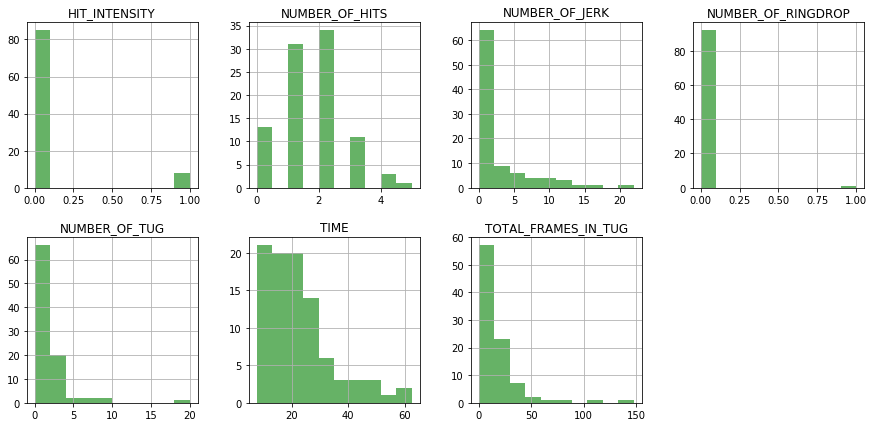

In [14]:
data_gt.hist(color='g', alpha=0.6, bins=10, layout=(2,4), figsize=(15,7))

In [15]:
feature_dict

{'E1_t10': [2, 0, 2, 23, 0, 11.96, 0],
 'E1_t11': [2, 0, 1, 19, 0, 12.96, 0],
 'E1_t12': [2, 0, 3, 26, 0, 20.96, 0],
 'E1_t1': [2, 1, 1, 9, 6, 19.96, 0],
 'E1_t2': [0, 0, 1, 3, 0, 10.68, 1],
 'E1_t3': [0, 0, 2, 19, 3, 8.96, 0],
 'E1_t4': [1, 0, 1, 17, 5, 16.84, 0],
 'E1_t5': [1, 0, 1, 15, 3, 11.0, 0],
 'E1_t6': [2, 0, 1, 16, 0, 12.96, 0],
 'E1_t7': [2, 1, 1, 31, 0, 17.76, 0],
 'E1_t8': [1, 0, 3, 12, 0, 12.92, 0],
 'E1_t9': [1, 0, 1, 18, 0, 7.64, 0],
 'E2_t10': [0, 0, 0, 0, 0, 9.56, 0],
 'E2_t11': [2, 0, 1, 8, 0, 20.84, 0],
 'E2_t12': [1, 1, 3, 26, 0, 27.52, 0],
 'E2_t1': [2, 0, 1, 5, 0, 20.0, 0],
 'E2_t2': [2, 0, 2, 42, 0, 19.84, 0],
 'E2_t3': [2, 0, 1, 23, 0, 11.68, 0],
 'E2_t4': [1, 0, 3, 18, 0, 17.68, 0],
 'E2_t5': [1, 0, 0, 0, 0, 11.84, 0],
 'E2_t6': [1, 0, 2, 37, 0, 17.84, 0],
 'E2_t7': [2, 0, 4, 76, 0, 26.88, 0],
 'E2_t8': [2, 0, 0, 0, 0, 16.0, 0],
 'E2_t9': [2, 0, 0, 0, 0, 19.68, 0],
 'E3_t10': [0, 0, 0, 0, 0, 8.76, 0],
 'E3_t11': [2, 0, 2, 24, 0, 15.64, 0],
 'E3_t12': [2, 0, 0,

In [16]:
## MIN MAX SCALLING
def normalize_min_max(a):
    return((a - np.min(a))/np.max(a))

def std_normalize(a):
    return((a - np.mean(a))/np.std(a))

def variance(a):
    return np.var(a)
    

In [17]:
def diff2D(indata) : # (fx+1 -fx)/ 1
    outdata=[]
    for i in range(len(indata)-1): # x_t+1 - x_t , y_t+1 - y_t
            outdata.append((indata[i + 1][0] - indata[i][0], indata[i + 1][1] - indata[i][1])); 
                           
    return outdata



In [18]:
#find curvature
def find_curvature(dx, ddx): #2d vector
    curvature = []
    for i in range(len(dx)-1):
        dd = pow(dx[i][0] * dx[i][0] + dx[i][1] * dx[i][1], 1.5)
        
        if(dd != 0) :
            curvature.append((abs((dx[i][0] * ddx[i][0]) - (dx[i][1] * ddx[i][1])))/ dd); 


    return curvature

In [19]:
#Arclength

def find_path_length(dx):#2d vector
    arc_length = 0
    
    for i in range(len(dx)):
        arc_length = arc_length+ pow((dx[i][0] * dx[i][0])+ (dx[i][1] * dx[i][1]), 0.5); 
        
    return arc_length;

In [20]:
def curvatureMaxnCount(curvature) :
    
    curvatureMax = 0; 
    curvatureMaxCount = 0; 
    
    if len(curvature) > 0:
        curvatureMax = curvature[0];

        for i in range(len(curvature)):

            if(abs(curvature[i]) > curvatureMax):
                curvatureMax = abs(curvature[i]); 

            if (abs(curvature[i]) > 300): #Hyperparameter : Define with respect to angle
                curvatureMaxCount = curvatureMaxCount+1; 

    return(curvatureMax, curvatureMaxCount)

In [21]:
def mean2D(data) : #2d np array input
    
    sumX, sumY = 0, 0;
    meanX, meanY = 0, 0;
    
    if(len(data)):
        for i in range(len(data)):
            sumX = sumX + data[i][0];
            sumY = sumY + data[i][1];

        meanX = sumX / len(data)
        meanY = sumY / len(data)
    
    return (meanX, meanY)

def max2D(data):
    
    maxX, maxY = 0, 0;
    
    if(len(data)):

        maxX = data[0][0];
        maxY = data[0][1];
        
        for i in range(len(data)):
            if (abs(data[i][0]) > maxX):
                maxX = abs(data[i][0]);
        
            if (abs(data[i][1]) > maxY):
                maxY = abs(data[i][1]);
    
    return  maxX, maxY

_
def var2D(indata): #2d np array

    meanX,meanY = 0, 0; 
    sumX, sumY = 0, 0; 
   
    sz = len(indata) - 1; 

    if( sz > 0):
        meanX, meanY = mean2D(indata); 
        
        for i in range(sz):

            sumX = sumX+ (indata[i][0] - meanX) * (indata[i][0] - meanX); 
            sumY = sumY+ (indata[i][1] - meanY) * (indata[i][1] - meanY); 


        sumX = sumX / sz; 

        sumY = sumY / sz; 
    
    return sumX, sumY


In [22]:
#find jerk
def find_jerk_vector(indata) : #2d vector
    jerk = []
    for i in range(len(indata)-3):
            jx = ((indata[i][0]) - (3 * indata[i + 1][0]) + (3 * indata[i + 2][0]) - (indata[i + 3][0]));
            jy = ((indata[i][1]) - (3 * indata[i + 1][1]) + (3 * indata[i + 2][1]) - (indata[i + 3][1]));
            ji = math.sqrt(jx*jx+ jy*jy)
            jerk.append(ji); 
            
    return jerk

In [23]:
def find_motion_smoothness(jerk): #1d vector
    j_tmp = 0
    for i in range(len(jerk)):
        j_tmp = j_tmp + (jerk[i]* jerk[i]); 
    motion_smoothness = math.sqrt (1/2 * j_tmp);
    return motion_smoothness

In [24]:
# motion_smoothness = find_motion_smoothness(jerk)

In [25]:
#                             M = cv2.moments(np.array(cnt, dtype = np.int32))
#                             cX = int(M["m10"] / M["m00"])
#                             cY = int(M["m01"] / M["m00"])

In [26]:
def find_right_corner(bbox):
    bbox = sorted(bbox,key=lambda x: x[1])[2:]
    
    if bbox[0][0] > bbox[1][0]:
        right_corner = bbox[0]
    else:
        right_corner = bbox[1]
    
    return right_corner[0], right_corner[1]

In [27]:
import sys 
#CENTROID BASED TRACKING
dir_root = "/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/"
dirs= [ "E1", "E2", "E3", "E4", "E5", "E6", "T1_1", "T3_2"] #
data_tracking = {}
var_data = {}
var_data_x={}
var_data_y={}
arc_length_data ={}
curvature_data = {}
X_data = {}
Y_data = {}
X_Y_data = {}
motion_smoothness_data = {}


for d in dirs:
    directory = os.path.join(dir_root,d)

    for folder in sorted(os.listdir(directory)):
        if ".avi" not in folder and ".xlsx" not in folder:
                shapes = {}

                root = os.path.join(dir_root+d,folder)
                lbl_files = sorted(glob.glob(root+"/*.json"))
                img_files = sorted(glob.glob(root+"/*.jpg"))
                for lbl_path in lbl_files:

                    ff = open(lbl_path)
                    data = json.load(ff)
                    img_path= root+"/"+data["imagePath"]
                    
#                     print(lbl_path)
#                     print(img_path)
                    for s in data["shapes"]:
                        if s["label"] not in shapes.keys():
                            
                            cnt = s["points"]
                            cnt = np.array(cnt, dtype = np.int32)
                            
                            rect = cv2.minAreaRect(cnt)
                            box = cv2.boxPoints(rect) # cv2.boxPoints(rect) for OpenCV 3.x
                            box = np.int0(box)
            
                            cX,cY = find_right_corner(box)
                                
                            shapes[s["label"]] = []
                            shapes[s["label"]].append((cX,cY))
                           


                        else:
                            cnt = s["points"]
                            cnt = np.array(cnt, dtype = np.int32)

                            rect = cv2.minAreaRect(cnt)
                            box = cv2.boxPoints(rect) # cv2.boxPoints(rect) for OpenCV 3.x
                            box = np.int0(box)

                            cX,cY = find_right_corner(box)

                            shapes[s["label"]].append((cX,cY))
                                    
                centroids_tool= np.array(shapes["tool"], dtype = np.int32)
                X,Y = centroids_tool.T
                
                x_norm = normalize_min_max(X)
                y_norm = normalize_min_max(Y)
                
                centroids = np.array(list(zip(x_norm, y_norm)), dtype = np.float)


#                 im = plt.imread(img_files[0])
#                 plt.figure(figsize = (8,12))

#                 plt.imshow(im)

#                 #put a red dot, size 40, at 2 locations:
#                 plt.plot(X,Y, 'o-', c='r')
#                 plt.title(folder)

#                 plt.savefig("/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/plots/"+folder+".jpg")          
                          
                diff_data_dx = diff2D(centroids) #gradient
                diff_data_ddx = diff2D(diff_data_dx)

                curvature = find_curvature(diff_data_dx, diff_data_ddx)
                arc_length = find_path_length(diff_data_dx)
                curvatureMax, curvatureMaxCount = curvatureMaxnCount(curvature)
                
                var_dx, var_dy = var2D(diff_data_dx) #variance of first derivative
                std_xy = math.sqrt(var_dx+var_dy)
                jerk = find_jerk_vector(centroids)
                motion_smoothness = find_motion_smoothness(jerk)
                
                mean_x = np.mean(x_norm)
                mean_y = np.mean(y_norm)
                var_x = np.var(x_norm)
                var_y = np.var(y_norm)

#                 feature_dict[folder]= feature_dict[folder]+[arc_length,np.mean(curvature),curvatureMax,curvatureMaxCount,mean_x, mean_y, var_x,var_y ]
                feature_dict[folder] = feature_dict[folder]+[std_xy, arc_length, curvatureMaxCount]
                var_data[folder] = std_xy
                var_data_x[folder] = var_dx
                var_data_y[folder] = var_dy
                arc_length_data[folder] = arc_length
                curvature_data[folder] = curvatureMaxCount
                X_data[folder] = X;
                Y_data[folder] = Y;
                X_Y_data[folder] = (X,Y)
                motion_smoothness_data[folder] = motion_smoothness





In [28]:
i=0
feature_vector = []
with open("features.csv", 'w', newline='') as csvfile:
    wr = csv.writer(csvfile, quoting=csv.QUOTE_ALL)
    wr.writerow(["VIDEO","NUMBER_OF_HITS", "HIT_INTENSITY", "NUMBER_OF_TUG", "TOTAL_FRAMES_IN_TUG","NUMBER_OF_JERK_FRAMES", "TIME", "NUMBER_OF_RINGDROP", "VARIANCE", "ARC_LENGTH", "CURVATURE_MAX_COUNT"])
    for key, val in feature_dict.items():
        out_list = [key]+val
        data[i]=out_list
        feature_vector.append(out_list)
        i=i+1
        wr.writerow(out_list)

In [29]:
y_data_val = var_data_y.values()

In [30]:
y_data_val

dict_values([0.0014105714626896824, 0.0021700751299594803, 0.0018999859368012682, 0.0012993418982219795, 0.0011725918670486986, 0.0023868218718689827, 0.0024688403137455607, 0.0022479413920462226, 0.0032676290448342793, 0.0009380816365703612, 0.0013516474775273418, 0.002310021533488876, 0.0016543918431487703, 0.003068470746286681, 0.0008080766157321402, 0.0010713591682622531, 0.001155874609859061, 0.002021858329646136, 0.0011814360271997367, 0.0015760093073255447, 0.00210850515609248, 0.0006729022247522573, 0.0013085456235902024, 0.0011068156053379164, 0.0012776695351733583, 0.001519785259152381, 0.000988084551478039, 0.0010277987728004813, 0.000892214141520274, 0.001735447917583407, 0.001315326315173763, 0.0014586736343911698, 0.0019730974847223183, 0.0010923291064947585, 0.0023181069667999404, 0.0012038500544323404, 0.0007504562422886567, 0.0026499355122043535, 0.0010172000814326534, 0.0008868745373606723, 0.0008130709642673316, 0.0030409566972263535, 0.00246661766631906, 0.001550715

In [31]:
len(list(var_data_y.keys())[20:])

73

In [32]:
len(var_data_y.keys())

93

<BarContainer object of 93 artists>

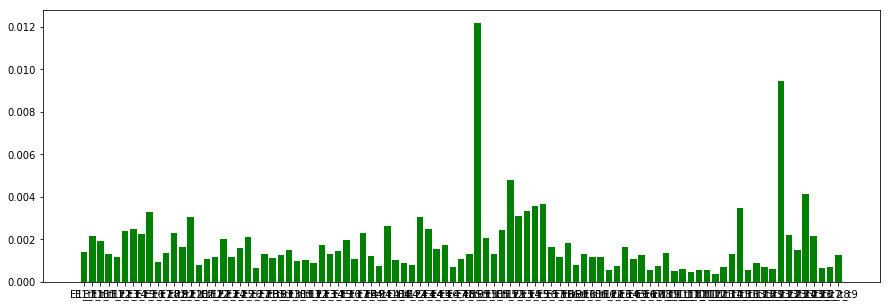

In [61]:
plt.figure(figsize=(15,5))
# plt.bar(list(var_data_y.keys())[40:65],list(var_data_y.values())[40:65] , color='g') 
plt.bar(var_data_y.keys(),var_data_y.values(), color='g') 

In [59]:
(list(zip(var_data_y.keys(),var_data_y.values())))

('T3_2_t9', 0.0012856110167628156)

In [35]:
data_gt = pd.DataFrame(feature_dict)
data_gt = data_gt.transpose()
data_gt.columns = ["NUMBER_OF_HITS", "HIT_INTENSITY", "NUMBER_OF_TUG", "TOTAL_FRAMES_IN_TUG", "NUMBER_OF_JERK", "TIME", "NUMBER_OF_RINGDROP", "VARIANCE", "ARC_LENGTH", "CURVATURE_MAX_COUNT"]

In [36]:
data_gt

,NUMBER_OF_HITS,HIT_INTENSITY,NUMBER_OF_TUG,TOTAL_FRAMES_IN_TUG,NUMBER_OF_JERK,TIME,NUMBER_OF_RINGDROP,VARIANCE,ARC_LENGTH,CURVATURE_MAX_COUNT
E1_t10,2.0,0.0,2.0,23.0,0.0,11.96,0.0,0.054081,2.801715,1.0
E1_t11,2.0,0.0,1.0,19.0,0.0,12.96,0.0,0.048060,2.638573,5.0
E1_t12,2.0,0.0,3.0,26.0,0.0,20.96,0.0,0.039564,3.522528,10.0
E1_t1,2.0,1.0,1.0,9.0,6.0,19.96,0.0,0.046704,3.224847,9.0
E1_t2,0.0,0.0,1.0,3.0,0.0,10.68,1.0,0.039239,1.886396,7.0
E1_t3,0.0,0.0,2.0,19.0,3.0,8.96,0.0,0.058930,2.086997,3.0
E1_t4,1.0,0.0,1.0,17.0,5.0,16.84,0.0,0.057878,3.858408,7.0
E1_t5,1.0,0.0,1.0,15.0,3.0,11.00,0.0,0.061005,2.589191,4.0
E1_t6,2.0,0.0,1.0,16.0,0.0,12.96,0.0,0.062915,3.272296,4.0
E1_t7,2.0,1.0,1.0,31.0,0.0,17.76,0.0,0.036587,2.682000,6.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd88ebc8160>,
      dtype=object)

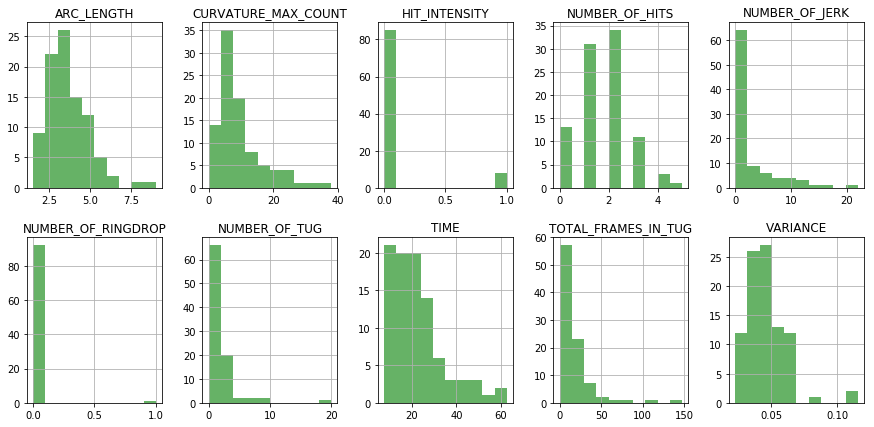

In [37]:
data_gt.hist(color='g', alpha=0.6, bins=10, layout=(2,5), figsize=(15,7))

In [38]:
normalized_data_gt=(data_gt-data_gt.min())/(data_gt.max()-data_gt.min())
#column wise normalize

In [39]:
normalized_data_gt

,NUMBER_OF_HITS,HIT_INTENSITY,NUMBER_OF_TUG,TOTAL_FRAMES_IN_TUG,NUMBER_OF_JERK,TIME,NUMBER_OF_RINGDROP,VARIANCE,ARC_LENGTH,CURVATURE_MAX_COUNT
E1_t10,0.4,0.0,0.10,0.155405,0.000000,0.078603,0.0,0.340096,0.170420,0.026316
E1_t11,0.4,0.0,0.05,0.128378,0.000000,0.096798,0.0,0.275642,0.148542,0.131579
E1_t12,0.4,0.0,0.15,0.175676,0.000000,0.242358,0.0,0.184697,0.267084,0.263158
E1_t1,0.4,1.0,0.05,0.060811,0.272727,0.224163,0.0,0.261132,0.227164,0.236842
E1_t2,0.0,0.0,0.05,0.020270,0.000000,0.055313,1.0,0.181222,0.047672,0.184211
E1_t3,0.0,0.0,0.10,0.128378,0.136364,0.024017,0.0,0.392002,0.074573,0.078947
E1_t4,0.2,0.0,0.05,0.114865,0.227273,0.167394,0.0,0.380739,0.312127,0.184211
E1_t5,0.2,0.0,0.05,0.101351,0.136364,0.061135,0.0,0.414221,0.141920,0.105263
E1_t6,0.4,0.0,0.05,0.108108,0.000000,0.096798,0.0,0.434658,0.233527,0.105263
E1_t7,0.4,1.0,0.05,0.209459,0.000000,0.184134,0.0,0.152831,0.154366,0.157895


In [40]:
normalized_data_gt.to_csv("scaled_features.csv")

In [41]:
df.set_index("Video")

,Hand-eye Coordination,Instrument-Tissue Manipulation,Dexterity,Flow of procedure,Effectualness,Overall
Video,,,,,,
E1_t1,3,3,3,3,4,15
E1_t2,3,3,3,2,1,8
E1_t3,4,3,4,4,4,18
E1_t4,3,2,4,4,4,16
E1_t5,3,3,4,4,4,17
E1_t6,3,3,4,4,4,17
E1_t7,4,4,4,4,4,20
E1_t8,3,3,4,4,4,17
E1_t9,4,4,4,4,4,20


In [42]:
JOINT = normalized_data_gt.join(df.set_index("Video"))

In [43]:
JOINT

,NUMBER_OF_HITS,HIT_INTENSITY,NUMBER_OF_TUG,TOTAL_FRAMES_IN_TUG,NUMBER_OF_JERK,TIME,NUMBER_OF_RINGDROP,VARIANCE,ARC_LENGTH,CURVATURE_MAX_COUNT,Hand-eye Coordination,Instrument-Tissue Manipulation,Dexterity,Flow of procedure,Effectualness,Overall
E1_t10,0.4,0.0,0.10,0.155405,0.000000,0.078603,0.0,0.340096,0.170420,0.026316,4,3,4,4,4,19
E1_t11,0.4,0.0,0.05,0.128378,0.000000,0.096798,0.0,0.275642,0.148542,0.131579,4,3,4,4,4,19
E1_t12,0.4,0.0,0.15,0.175676,0.000000,0.242358,0.0,0.184697,0.267084,0.263158,4,2,4,4,4,18
E1_t1,0.4,1.0,0.05,0.060811,0.272727,0.224163,0.0,0.261132,0.227164,0.236842,3,3,3,3,4,15
E1_t2,0.0,0.0,0.05,0.020270,0.000000,0.055313,1.0,0.181222,0.047672,0.184211,3,3,3,2,1,8
E1_t3,0.0,0.0,0.10,0.128378,0.136364,0.024017,0.0,0.392002,0.074573,0.078947,4,3,4,4,4,18
E1_t4,0.2,0.0,0.05,0.114865,0.227273,0.167394,0.0,0.380739,0.312127,0.184211,3,2,4,4,4,16
E1_t5,0.2,0.0,0.05,0.101351,0.136364,0.061135,0.0,0.414221,0.141920,0.105263,3,3,4,4,4,17
E1_t6,0.4,0.0,0.05,0.108108,0.000000,0.096798,0.0,0.434658,0.233527,0.105263,3,3,4,4,4,17
E1_t7,0.4,1.0,0.05,0.209459,0.000000,0.184134,0.0,0.152831,0.154366,0.157895,4,4,4,4,4,20


In [44]:
normalized_data_gt.columns

Index(['NUMBER_OF_HITS', 'HIT_INTENSITY', 'NUMBER_OF_TUG',
       'TOTAL_FRAMES_IN_TUG', 'NUMBER_OF_JERK', 'TIME', 'NUMBER_OF_RINGDROP',
       'VARIANCE', 'ARC_LENGTH', 'CURVATURE_MAX_COUNT'],
      dtype='object')

In [45]:
Y = JOINT["Overall"]

In [46]:
X = JOINT[['NUMBER_OF_HITS', 'HIT_INTENSITY', 'NUMBER_OF_TUG',
       'TOTAL_FRAMES_IN_TUG', 'NUMBER_OF_JERK', 'TIME', 'NUMBER_OF_RINGDROP',
       'VARIANCE', 'ARC_LENGTH', 'CURVATURE_MAX_COUNT']]

In [47]:
X

,NUMBER_OF_HITS,HIT_INTENSITY,NUMBER_OF_TUG,TOTAL_FRAMES_IN_TUG,NUMBER_OF_JERK,TIME,NUMBER_OF_RINGDROP,VARIANCE,ARC_LENGTH,CURVATURE_MAX_COUNT
E1_t10,0.4,0.0,0.10,0.155405,0.000000,0.078603,0.0,0.340096,0.170420,0.026316
E1_t11,0.4,0.0,0.05,0.128378,0.000000,0.096798,0.0,0.275642,0.148542,0.131579
E1_t12,0.4,0.0,0.15,0.175676,0.000000,0.242358,0.0,0.184697,0.267084,0.263158
E1_t1,0.4,1.0,0.05,0.060811,0.272727,0.224163,0.0,0.261132,0.227164,0.236842
E1_t2,0.0,0.0,0.05,0.020270,0.000000,0.055313,1.0,0.181222,0.047672,0.184211
E1_t3,0.0,0.0,0.10,0.128378,0.136364,0.024017,0.0,0.392002,0.074573,0.078947
E1_t4,0.2,0.0,0.05,0.114865,0.227273,0.167394,0.0,0.380739,0.312127,0.184211
E1_t5,0.2,0.0,0.05,0.101351,0.136364,0.061135,0.0,0.414221,0.141920,0.105263
E1_t6,0.4,0.0,0.05,0.108108,0.000000,0.096798,0.0,0.434658,0.233527,0.105263
E1_t7,0.4,1.0,0.05,0.209459,0.000000,0.184134,0.0,0.152831,0.154366,0.157895


In [48]:
Y

E1_t10      19
E1_t11      19
E1_t12      18
E1_t1       15
E1_t2        8
E1_t3       18
E1_t4       16
E1_t5       17
E1_t6       17
E1_t7       20
E1_t8       17
E1_t9       20
E2_t10      20
E2_t11      18
E2_t12      17
E2_t1       19
E2_t2       17
E2_t3       20
E2_t4       17
E2_t5       20
E2_t6       17
E2_t7       17
E2_t8       20
E2_t9       20
E3_t10      19
E3_t11      17
E3_t12      20
E3_t1       19
E3_t2       19
E3_t3       20
            ..
E6_t1       18
E6_t2       16
E6_t3       20
E6_t4       19
E6_t5       20
E6_t6       18
E6_t7       14
E6_t8       18
E6_t9       15
T1_1_t10    11
T1_1_t11    13
T1_1_t12    11
T1_1_t1     11
T1_1_t2     10
T1_1_t3     10
T1_1_t4     11
T1_1_t5     10
T1_1_t6      8
T1_1_t7      7
T1_1_t8      5
T1_1_t9      8
T3_2_t1     15
T3_2_t2     15
T3_2_t3     16
T3_2_t4     15
T3_2_t5     16
T3_2_t6     13
T3_2_t7     13
T3_2_t8     10
T3_2_t9     13
Name: Overall, Length: 93, dtype: int64

In [49]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=40) #70 | 30

In [50]:
from sklearn.decomposition import PCA

pca = PCA(3) # EXPLAINATION ?
X_train_vis = pca.fit_transform(X_train)
X_test_vis = pca.transform(X_test)

In [51]:
print(pca.explained_variance_) # EXPLAiNATION ?

[0.12683393 0.08505189 0.04338759]


In [52]:
X_train_vis #3 COMPONENT

array([[-2.03408604e-01,  1.38115350e-01,  4.95476631e-01],
       [ 5.82266661e-04, -7.62595029e-02, -1.36827027e-01],
       [ 4.29230263e-01, -5.27676902e-01,  1.51222887e-01],
       [-4.48554318e-01,  7.54674700e-02, -4.11534076e-01],
       [ 1.33885939e-01, -6.12730086e-02, -1.38137337e-01],
       [-8.73053922e-02,  1.25584659e-01,  3.14669005e-01],
       [-1.44280033e-01,  4.05760933e-02,  1.17646705e-01],
       [-2.33754769e-01,  1.54311869e-01,  5.26512682e-01],
       [ 4.81919220e-01, -6.94231104e-01, -5.16808730e-02],
       [-1.52329327e-01,  6.08615731e-02, -8.81297617e-02],
       [-4.13561467e-01,  1.82710670e-01, -6.29791167e-02],
       [-4.61053957e-01,  1.29118892e-01, -1.78239505e-01],
       [ 2.54496599e-02, -1.82469387e-01, -7.44828052e-02],
       [ 5.58538262e-01, -7.16159165e-01, -2.70942873e-01],
       [-2.01433286e-01,  1.39327391e-02,  1.58909917e-01],
       [ 1.75879315e-01, -1.56327062e-01,  3.44282807e-01],
       [-1.38610470e-01, -1.46548490e-01

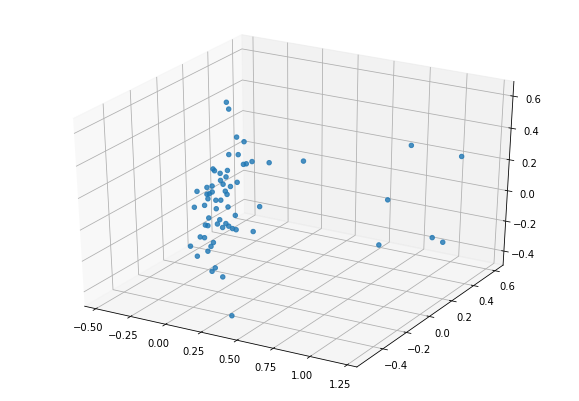

In [53]:
"""################### PCA 3d PLOT ##############################################"""

from mpl_toolkits import mplot3d 

def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)

fig = plt.figure(figsize = (10, 7)) 
ax = plt.axes(projection ="3d") 

    # plot data
ax.scatter3D(X_train_vis[:, 0], X_train_vis[:, 1],X_train_vis[:, 2], alpha=0.8)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
#     draw_vector(pca.mean_, pca.mean_ + v)
plt.axis('equal');


In [54]:
################################# OPTION 0 : UNSUPERVISED CLUSTERING ###################################

In [55]:
from sklearn.cluster import KMeans

In [1]:
estimator = KMeans(n_clusters=5)

NameError: name 'KMeans' is not defined

In [57]:
estimator.fit(X_train_vis)

KMeans(n_clusters=5)

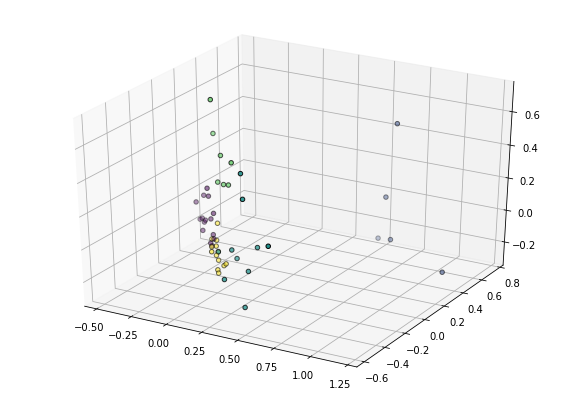

In [58]:
labels = estimator.labels_
fig = plt.figure(figsize = (10, 7)) 
ax = plt.axes(projection ="3d") 

ax.scatter(X_train_vis[:, 0], X_train_vis[:, 1], X_train_vis[:, 2],
           c=labels.astype(np.float), edgecolor='k')

In [59]:
##################  OPTION 1 : SUPERVISED FOR OVERALL SCORE WITH BINNING OF LABELS      ################

In [60]:
y_train_labels = np.digitize(np.array(y_train),np.array([5.0, 10.0, 15.0, 20.0]))

In [61]:
y_train_labels

array([3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 4, 3, 4, 4, 3, 2, 3, 3, 3, 3, 3, 3,
       3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 4, 4,
       4, 4, 3, 3, 3, 3])

In [62]:
#Random Forest Test
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(max_depth=5, random_state=40)
classifier.fit(X_train, y_train_labels)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

In [63]:
y_test_labels = np.digitize(np.array(y_test),np.array([5.0, 10.0, 15.0, 20.0]))

In [63]:
y_pred

array([3, 3, 3, 3, 4, 3, 3, 4, 4, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3])

In [64]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

cm = confusion_matrix(y_test, y_pred) 
print(cm)
print('Accuracy' ,accuracy_score(y_test_labels, y_pred))

[[0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0]
 [2 0 0 0 0 0 0 0 0]
 [3 0 0 0 0 0 0 0 0]
 [5 0 0 0 0 0 0 0 0]
 [3 1 0 0 0 0 0 0 0]
 [2 1 0 0 0 0 0 0 0]
 [2 2 0 0 0 0 0 0 0]]
Accuracy 0.7727272727272727


In [65]:
y_test_labels

array([3, 3, 3, 3, 4, 3, 1, 3, 3, 3, 4, 3, 4, 3, 3, 3, 3, 3, 3, 4, 3, 3])

In [66]:
y_pred

array([3, 3, 3, 3, 4, 3, 3, 4, 4, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3])

In [67]:
#################### OPTION 2 #################################################################

In [68]:
print(__doc__)


# Code source: Gaël Varoquaux
#              Andreas Müller
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier, GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import cross_val_score


h = .02  # step size in the mesh

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

Regressors = [
    KNeighborsRegressor(3),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestRegressor(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

Y = np.digitize(np.array(Y),np.array([5.0, 10.0, 15.0, 20.0]))
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=40) #70 | 30


# iterate over classifiers
for name, clf in zip(names, classifiers):
    try :
        scores = cross_val_score(clf, X_train, y_train, cv=10)
        

        print(np.mean(scores), clf)
    except:
        print(clf)
        

#     # Plot the decision boundary. For that, we will assign a color to each
#     # point in the mesh [x_min, x_max]x[y_min, y_max].
#     if hasattr(clf, "decision_function"):
#         Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
#     else:
#         Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

#     # Put the result into a color plot
#     Z = Z.reshape(xx.shape)
#     ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

#     # Plot the training points
#     ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
#                edgecolors='k')
#     # Plot the testing points
#     ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
#                edgecolors='k', alpha=0.6)

#     ax.set_xlim(xx.min(), xx.max())
#     ax.set_ylim(yy.min(), yy.max())
#     ax.set_xticks(())
#     ax.set_yticks(())
#     if ds_cnt == 0:
#         ax.set_title(name)
#     ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
#             size=15, horizontalalignment='right')
#     i += 1

# plt.tight_layout()
# plt.show()

################### PCA 3d PLOT ##############################################


NameError: name 'RandomForestRegressor' is not defined

In [ ]:
##############################################################################################################

In [115]:
double varX = 0; 

double varY = 0; 

double arcLength = 0; 

double curvatureMax = 0; 

int curvatureMaxCount = 0; 

vector<pair <double, double > > x; 

vector<pair <double, double > > dx; 

vector<pair <double, double > > ddx; 

vector<double> Curvature; 

 vector<pair <double, double > > data = result.grasping.trackingData[i].second; 

qDebug() << " grasping normalize enter\n"; 

util::normalize2D(data, x); 

qDebug() << " data size \n" << data.size(); 

qDebug() << " x normalized data \n" << x.size(); 

for(int i = 0; i < x.size(); i++) 

{ 

      qDebug() << "x[i] - " << x[i] << endl; 

} 

qDebug() << " grasping diff2d enter 1\n"; 

 util::diff2D(x, dx); 

qDebug() << "grasping diff2d enter 2\n"; 

util::diff2D(dx, ddx); 

qDebug() << " grasping var2d enter 1\n"; 

util::var2D(dx, &varX, &varY); 

qDebug() << "grasping curvature enter 1\n"; 

util::curvature(dx, ddx, Curvature); 

qDebug() << "grasping curvature max count enter\n"; 

 util::curvatureMaxnCount(Curvature, &curvatureMax, &curvatureMaxCount); 

qDebug() << "grasping arclength enter\n"; 

util::arclength(dx, &arcLength); 

result.grasping.curvatureMax.push_back(make_pair(result.grasping.trackingData[i].first, curvatureMax)); 

result.grasping.arcLength.push_back(make_pair(result.grasping.trackingData[i].first, arcLength)); 

result.grasping.curvatureMaxCount.push_back(make_pair(result.grasping.trackingData[i].first, curvatureMaxCount)); 



_________________________________________________________________________________ 

void util::normalize2D(const vector<pair <double, double > > &indata, vector<pair <double, double > > &outdata) 

{ 

    double meanX = 0; double meanY = 0; 

    double maxX = 0; double maxY = 0; 

    mean2D(indata, &meanX, &meanY); 

    outdata.clear(); 

    if(indata.size()) 

    { 

        for (int i = 0; i < indata.size(); ++i) 

        { 

            outdata.push_back(make_pair(indata[i].first - meanX, indata[i].second - meanY)); 

        } 

        max2D(outdata, &maxX, &maxY); 

        for (int i = 0; i < outdata.size(); ++i) 

        { 

            if(maxX != 0 && maxY != 0) 

            { 

                outdata[i].first = (outdata[i].first) / maxX; 

                outdata[i].second = (outdata[i].second) / maxY; 

            } 

        } 

    } 

} 

 _________________________________________________________________________________ 

void util::diff2D(const vector<pair <double, double > > &indata, vector<pair <double, double > > &outdata) 

{ 

    outdata.clear(); 

    int sz = ((int)indata.size())-1; 

    if( sz > 0) 

    { 

        for (int i = 0; i < sz ; ++i) 

        { 

            outdata.push_back(make_pair(indata[i + 1].first - indata[i].first, indata[i + 1].second - indata[i].second)); 

        } 

    } 

} 

 _______________________________________________________________________________ 

void util::var2D(const vector<pair <double, double > > &indata, double *varX, double *varY) 

{ 

    int sz = ((int)indata.size()) - 1; 

    if( sz > 0) 

    { 

        double meanX = 0; double meanY = 0; 

        double sumX = 0; double sumY = 0; 

        mean2D(indata, &meanX, &meanY); 

        for (int i = 0; i < sz ; ++i) 

        { 

            sumX += (indata[i].first - meanX) * (indata[i].first - meanX); 

            sumY += (indata[i].second - meanY) * (indata[i].second - meanY); 

        } 

        sumX /= indata.size() - 1; 

        sumY /= indata.size() - 1; 

    } 

} 

_________________________________________________________________________________ 

void util::curvature(const vector<pair <double, double > > &dx, 

    const vector<pair <double, double > > &ddx, 

    vector<double> &curvature) 

{ 

    curvature.clear(); 

    if(ddx.size()) 

    { 

        for (int i = 0; i < ddx.size(); ++i) 

        { 

            double dd = pow(dx[i].first * dx[i].first + dx[i].second * dx[i].second, 1.5); 

            if(dd != 0) 

            { 

                curvature.push_back(abs((dx[i].first * ddx[i].second) - (dx[i].second * ddx[i].first)) / dd); 

            } 

        } 

    } 

} 

_________________________________________________________________________________  

void util::arclength(const vector<pair <double, double > > &dx, double *arcLength) 

{ 

    if(dx.size()) 

    { 

        *arcLength = 0; 

        for (int i = 0; i < dx.size(); ++i) 

        { 

            *arcLength += pow(dx[i].first * dx[i].first + dx[i].second * dx[i].second, 0.5); 

        } 

    } 

} 

_____________________________________________________________________________ 

void util::curvatureMaxnCount(const vector<double > &curvature, double *curvatureMax, int*curvatureMaxCount) 

{ 

    if (curvature.size()) 

    { 

        *curvatureMax = curvature[0]; 

        for (int i = 1; i < curvature.size(); ++i) 

        { 

            if (abs(curvature[i]) > *curvatureMax) 

            { 

                *curvatureMax = abs(curvature[i]); 

            } 

            if (abs(curvature[i]) > 300) 

            { 

                *curvatureMaxCount++; 

            } 

        } 

    } 

    else 

    { 

        *curvatureMax = 0; 

        *curvatureMaxCount = 0; 

    } 

} 


SyntaxError: invalid syntax (<ipython-input-115-21fb722a18f5>, line 1)

In [61]:
tug = [0,0,0,0,0,0,0,0,1,1,1,1,1,1,0,0,0,0,0,1,1,1,1,0,0,0,0,0,1,1,0,1,1,1,1,1,1]
tug_event=0
count=0; #000000111100000011000000111110000000
tug.append(0)
total = 0
for i in range(len(tug)):
    if tug[i]==1:
        count= count+1;

    if tug[i]==0 and count:
        total=total+count
        count = 0
        tug_event = tug_event +1

In [62]:
tug_event

4

In [63]:
total

18